## Imports

In [40]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import glob
%matplotlib inline

## Detect image and convert colors

In [41]:
def threshold_rel(img, lo, hi):
    vmin = np.min(img)
    vmax = np.max(img)
    
    vlo = vmin + (vmax - vmin) * lo
    vhi = vmin + (vmax - vmin) * hi
    return np.uint8((img >= vlo) & (img <= vhi)) * 255

def threshold_abs(img, lo, hi):
    return np.uint8((img >= lo) & (img <= hi)) * 255


def getHLSImage(img): 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    v_channel = hsv[:,:,2]

    right_lane = threshold_rel(l_channel, 0.8, 1.0)
    right_lane[:,:750] = 0

    left_lane = threshold_abs(h_channel, 20, 30)
    left_lane &= threshold_rel(v_channel, 0.7, 1.0)
    left_lane[:,550:] = 0

    finalImg = left_lane | right_lane
    return finalImg


def plotImage(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


## Canny Edge Detection

In [42]:
# h1 = 100
# h2 = 200
def cannyEdgeDetection(img, h1 = 160, h2= 170):
    blurredImg = cv2.GaussianBlur(img, (5,5), 0)
    cannyImg = cv2.Canny(blurredImg, h1 ,h2)
    return cannyImg

## Image Masking

In [43]:
def regionOfInterest(img, color):
    height = img.shape[0]
    width = img.shape[1]
    regionOfInterest = [
        (0, height),
        (width/2, height/2),
        (width, height)
    ]
    rectangle = np.array([regionOfInterest], np.int32)
    mask = np.zeros_like(img)
    # all pixels will be black
    cv2.fillPoly(mask, rectangle, color)
    return mask

In [44]:
def maskImage(img):
    mask = regionOfInterest(img, 255)
    # plt.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
    maskedImage = cv2.bitwise_and(img, mask)
    return maskedImage

## Perspective Transform

Applying transform to the image to see it in the bird's eye view

In [45]:
""" Assigning the source and destination points for the perspective transform """
# coordinates = [x, y]
top_left = [510, 480]
top_right = [780, 480]
bottom_left = [270, 690]
bottom_right = [1230, 690]


srcPoints = np.array([
    top_left,
    top_right,
    bottom_left,
    bottom_right,

]).astype(np.float32)

dstPoints = np.array([
    [0, 0],
    [550, 0],
    [0, 350],
    [550, 350],
]).astype(np.float32)

warpedImgSize = (550, 350) # (width, height) for transformed image

''' Perspective transform functions for the lane detection '''
def perspectiveTransform(srcPoints, dstPoints):
    M = cv2.getPerspectiveTransform(srcPoints, dstPoints)
    Minv = cv2.getPerspectiveTransform(dstPoints, srcPoints)
    return M, Minv


def warpPerspective(img, imgSize, M):
    return cv2.warpPerspective(img, M, imgSize, cv2.INTER_LINEAR)


def transformImage(img, source, destination, imgSize):
    """ transform the image to bird's eye view """

    M, Minv = perspectiveTransform(source, destination)
    warpedImg = warpPerspective(img, imgSize, M)
    # plotImage(warpedImg)
    return warpedImg


## Image Overlay

In [46]:
def overlayImage(bgImage, overlayImage, xOffset, yOffset, scaling):
    scalingPercentage = scaling
    width = int(overlayImage.shape[1] * scalingPercentage / 100)
    height = int(overlayImage.shape[0] * scalingPercentage / 100)
    dsize = (width, height)
    resizedOverlay = cv2.resize(overlayImage, dsize)
    stackedOverlay = np.zeros_like(resizedOverlay, shape = (resizedOverlay.shape[0],resizedOverlay.shape[1],3))
    stackedOverlay[:,:,0] = resizedOverlay
    stackedOverlay[:,:,1] = resizedOverlay
    stackedOverlay[:,:,2] = resizedOverlay
    # overlay image on top of original image

    bgImage[yOffset:yOffset+stackedOverlay.shape[0], xOffset:xOffset+stackedOverlay.shape[1]] = stackedOverlay
    return bgImage

## Sliding Window

In [47]:
def slidingWindow(img_w):

    histogram = np.sum(img_w[int(img_w.shape[0] / 2):, :], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img_w, img_w, img_w)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = int(histogram.shape[0] / 2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = int(img_w.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img_w.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
      
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img_w.shape[0] - (window + 1) * window_height
        win_y_high = img_w.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (
            nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (
            nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
          
          leftx_current = int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
          
          rightx_current = int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_w.shape[0] - 1, img_w.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    # plt.imshow(out_img)
    # plt.plot(left_fitx, ploty, color='yellow')
    # plt.plot(right_fitx, ploty, color='yellow')
    # plt.xlim(0, 1280)
    # plt.ylim(720, 0)

    return left_fit, right_fit, out_img

## Draw Lines on Image

In [49]:
def drawLines(img, img_w, left_fit, right_fit, perspective):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(img_w).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    #color_warp_center = np.dstack((warp_zero, warp_zero, warp_zero))

    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])

    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    #cv2.fillPoly(color_warp_center, np.int_([pts]), (0, 255, 0))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = transformImage(color_warp, perspective[1], perspective[0], (1280,720))
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.2, 0)

    color_warp_lines = np.dstack((warp_zero, warp_zero, warp_zero))
    cv2.polylines(color_warp_lines, np.int_([pts_right]), isClosed=False, color=(255, 255, 0), thickness=25)
    cv2.polylines(color_warp_lines, np.int_([pts_left]), isClosed=False, color=(0, 0, 255), thickness=25)
    newwarp_lines = transformImage(color_warp_lines, perspective[1], perspective[0], (1280,720))

    result = cv2.addWeighted(result, 1, newwarp_lines, 1, 0)
    return result

## Calculations

In [50]:
def calculate_center_distance(img, left_fit, right_fit):
    CAR_DEFAULT_WIDTH_IN_CM = 180
    pixelWidthInCm = CAR_DEFAULT_WIDTH_IN_CM/img.shape[1]
    midPointOfLanes = (right_fit[2]+left_fit[2])/2
    carCenter = img.shape[0]/2
    distance = pixelWidthInCm*(abs(carCenter-midPointOfLanes))
    distanceInM = str(round(distance/100, 4))
    return distanceInM

def calc_radius(img, left_fit, right_fit):
    ploty = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0] * ploty ** 2 + left_fit[1] * ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty ** 2 + right_fit[1] * ploty + right_fit[2]

    img_height = img.shape[0]
    y_eval = img_height

    ym_per_pix = 30 / 720.  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    ploty = np.linspace(0, img_height - 1, img_height)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, left_fitx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, right_fitx * xm_per_pix, 2)

    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])

    right_curverad = (
                         (1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    return round((float(left_curverad) + float(right_curverad))/2.,2) 
    
def draw_text_on_photo(img, text):
    result = img
    for i, line in enumerate(text.split('\n')):
        i = 50 + 20 * i
        cv2.putText(result, line, (20, i), cv2.FONT_HERSHEY_DUPLEX,
                    0.5, (255, 255, 255), 1, cv2.LINE_AA)
    return result

## Show all images together

In [51]:
def showImages(images, cmap=None):
    cols = 2
    rows = (len(images)+1)//cols
    
    plt.figure(figsize=(10, 11))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)
        # use gray scale color map if there is only one channel
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap=cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

## Pipeline

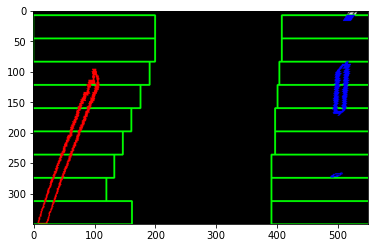

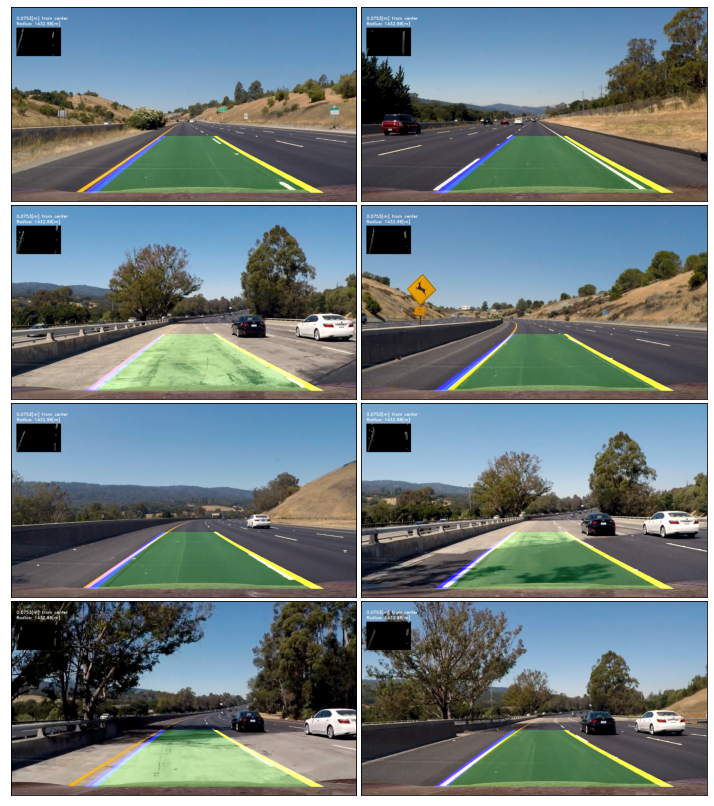

In [52]:
testImages = [plt.imread(path) for path in glob.glob('./test_images/*.jpg')]
finalImages = []
MOV_AVG_LENGTH = 5
for img in testImages:
    HLSImg = getHLSImage(img)
    cannyImg = cannyEdgeDetection(HLSImg)
    maskedImage = maskImage(cannyImg)
    transformedImage = transformImage(maskedImage, srcPoints, dstPoints, (550,350))
    try:
      left_fit, right_fit = slidingWindow(transformedImage)
      mov_avg_left = np.array([left_fit])
      mov_avg_right = np.array([right_fit])
    except:
      pass

    left_fit = np.array([np.mean(mov_avg_left[::-1][:,0][0:MOV_AVG_LENGTH]),
                                np.mean(mov_avg_left[::-1][:,1][0:MOV_AVG_LENGTH]),
                                np.mean(mov_avg_left[::-1][:,2][0:MOV_AVG_LENGTH])])
    right_fit = np.array([np.mean(mov_avg_right[::-1][:,0][0:MOV_AVG_LENGTH]),
                                np.mean(mov_avg_right[::-1][:,1][0:MOV_AVG_LENGTH]),
                                np.mean(mov_avg_right[::-1][:,2][0:MOV_AVG_LENGTH])])

    if mov_avg_left.shape[0] > 1000:
        
        mov_avg_left = mov_avg_left[0:MOV_AVG_LENGTH]
    if mov_avg_right.shape[0] > 1000:
        mov_avg_right = mov_avg_right[0:MOV_AVG_LENGTH]
    final = drawLines(img, transformedImage, left_fit, right_fit, perspective=[srcPoints, dstPoints])
    final = overlayImage(final, transformedImage,20, 80, 30)

    # CALCULATIONS 
    distance_from_center = calculate_center_distance(final, left_fit, right_fit)
    radius_of_lane = calc_radius(final, left_fit, right_fit)
    finalResultImage = draw_text_on_photo(final, (
        str(distance_from_center)+"[m] from center \n"+
        "Radius:"+" "+str(radius_of_lane)+"[m]"
        )
    )
    finalImages.append(finalResultImage)

showImages(finalImages)